In [1]:
from numpy.random import randint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanAbsoluteError, MeanSquaredError, SparseCategoricalCrossentropy
from tensorflow.keras.initializers import  HeNormal
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
  Input, Conv2D, Conv2DTranspose, LeakyReLU, MaxPooling2D,
  Activation, Concatenate, BatchNormalization, ZeroPadding2D
)
import numpy as np
import cv2
import tensorflow as tf
import matplotlib.pyplot as plt
from glob import glob
import os
from tensorflow.keras.models import Model
from tqdm.notebook import tqdm
from skimage.color import rgb2lab, lab2rgb
import os

%matplotlib inline

In [2]:
pos_threshold = 0.5
neg_threshold = 0.1
iou_threshold = 0.5
grid_width = 16
grid_height = 16
image_width = 640
image_height = 480
buffer_size=1000
batch_size=2
n_rois = 4

label_dir = "dataset/test.csv"
dataset_dir = "dataset/BCCD"
n_grids_x = int(image_width / grid_width)
n_grids_y = int(image_height / grid_height)
print(n_grids_x)
print(n_grids_y)


40
30


In [3]:
wandhG = np.array([[100.0, 100.0], [300.0, 300.0], [500.0, 500.0],
                   [200.0, 100.0], [370.0, 185.0], [440.0, 220.0],
                   [100.0, 200.0], [185.0, 370.0], [220.0, 440.0]])

In [4]:
def compute_iou(boxes1, boxes2):
    """(xmin, ymin, xmax, ymax)
    boxes1 shape:  [-1, 4], boxes2 shape: [-1, 4]
    """
    left_up = np.maximum(boxes1[..., :2], boxes2[..., :2], )
    right_down = np.minimum(boxes1[..., 2:], boxes2[..., 2:])
    inter_wh = np.maximum(right_down - left_up, 0.0)
    inter_area = inter_wh[..., 0] * inter_wh[..., 1]

    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])

    union_area = boxes1_area + boxes2_area - inter_area
    ious = inter_area / union_area
    return ious

In [5]:
def plot_boxes_on_image(show_image_with_boxes, boxes, color=[0, 0, 255], thickness=2):
    for box in boxes:
        cv2.rectangle(show_image_with_boxes,
                pt1=(int(box[0]), int(box[1])),
                pt2=(int(box[2]), int(box[3])), color=color, thickness=thickness)
    show_image_with_boxes = cv2.cvtColor(show_image_with_boxes, cv2.COLOR_BGR2RGB)
    return show_image_with_boxes

In [6]:
def load_gt_boxes(path, filename=None):
    """
    Don't care about what shit it is. whatever, this function
    returns many ground truth boxes with the shape of [-1, 4].

    xmin, ymin, xmax, ymax
    """
    bbs = open(path).readlines()[1:]

    roi = np.zeros(shape=(len(bbs), 4))
    
    idx = 0
    if filename is not None:
      for bb in bbs:
        bb = bb.replace('\n', '').split(',')
        filename_ = bb[0]
        if filename_ == filename:
          bba = np.array([float(bb[i]) for i in [2,4,3,5]])
          roi[idx] = bba
          idx+=1
    
    return np.array(roi)

In [7]:
def compute_regression(box1, box2):
    """
    box1: ground-truth boxes
    box2: anchor boxes
    """
    target_reg = np.zeros(shape=[4,])
    w1 = box1[2] - box1[0]
    h1 = box1[3] - box1[1]
    w2 = box2[2] - box2[0]
    h2 = box2[3] - box2[1]

    target_reg[0] = (box1[0] - box2[0]) / w2
    target_reg[1] = (box1[1] - box2[1]) / h2
    target_reg[2] = np.log(w1 / w2)
    target_reg[3] = np.log(h1 / h2)

    return target_reg

In [8]:
def decode_output(pred_bboxes, pred_scores, score_thresh=0.5):
    """
    pred_bboxes shape: [1, 45, 60, 9, 4]
    pred_scores shape: [1, 45, 60, 9, 2]
    """
    grid_x, grid_y = tf.range(n_grids_x, dtype=tf.int32), tf.range(n_grids_y, dtype=tf.int32)
    grid_x, grid_y = tf.meshgrid(grid_x, grid_y)
    grid_x, grid_y = tf.expand_dims(grid_x, -1), tf.expand_dims(grid_y, -1)
    grid_xy = tf.stack([grid_x, grid_y], axis=-1)
    center_xy = grid_xy * grid_width + grid_width//2
    center_xy = tf.cast(center_xy, tf.float32)
    anchor_xymin = center_xy - 0.5 * wandhG

    xy_min = pred_bboxes[..., 0:2] * wandhG[:, 0:2] + anchor_xymin
    xy_max = tf.exp(pred_bboxes[..., 2:4]) * wandhG[:, 0:2] + xy_min

    pred_bboxes = tf.concat([xy_min, xy_max], axis=-1)
    pred_scores = pred_scores[..., 1]
    score_mask = pred_scores > score_thresh
    pred_bboxes = tf.reshape(pred_bboxes[score_mask], shape=[-1,4]).numpy()
    pred_scores = tf.reshape(pred_scores[score_mask], shape=[-1,]).numpy()
    return pred_bboxes, pred_scores

In [9]:
def nms(pred_boxes, pred_score, iou_thresh=iou_threshold):
    """
    pred_boxes shape: [-1, 4]
    pred_score shape: [-1,]
    """
    selected_boxes = []
    while len(pred_boxes) > 0:
      max_idx = np.argmax(pred_score)
      selected_box = pred_boxes[max_idx]
      selected_boxes.append(selected_box)
      pred_boxes = np.concatenate([pred_boxes[:max_idx], pred_boxes[max_idx+1:]])
      pred_score = np.concatenate([pred_score[:max_idx], pred_score[max_idx+1:]])
      ious = compute_iou(selected_box, pred_boxes)
      iou_mask = ious <= 0.1
      pred_boxes = pred_boxes[iou_mask]
      pred_score = pred_score[iou_mask]

    selected_boxes = np.array(selected_boxes)
    return selected_boxes

In [10]:
# We use feature pyramid by concantenation instead of addition

def feature_gen(images_tensor):
  input = images_tensor
  x = Conv2D(64, 3, activation="relu", padding="same")(input)
  x = Conv2D(64, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)

  # 2nd
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = Conv2D(128, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)

  # 3rd
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = Conv2D(256, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)
  
  pool3_p = MaxPooling2D(2, strides=2, padding='same')(x)
  pool3_p = Conv2D(256, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(pool3_p)
  
  # 4th
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = MaxPooling2D(2, strides=2, padding='same')(x)
  pool4_p = Conv2D(512, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(x)
  
  # 5th
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  x = Conv2D(512, 3, activation='relu', padding='same')(x)
  pool5_p = Conv2D(512, kernel_size=[5,2], activation="relu", padding='same', use_bias=False)(x)
  
  feature = tf.concat([pool3_p, pool4_p, pool5_p], axis=-1)
  #   shape (-1, height/16, widht/16, 512)
  return feature

In [11]:
def get_RPN():
  # 1st
  input = Input(shape=(image_height, image_width, 3))
  feature = feature_gen(input)   #   spatial dimension = original / 16

  #   conv feature to get desired number of filters that match 9*2 and 9*4
  #   they are to be reshaped
  conv_cls_scores = Conv2D(18, kernel_size=1, padding='same', use_bias=False)(feature)
  conv_cls_bboxes = Conv2D(36, kernel_size=1, padding='same', use_bias=False)(feature)
  
  cls_scores = tf.reshape(conv_cls_scores, (-1, n_grids_y, n_grids_x, 9, 2))
  cls_bboxes = tf.reshape(conv_cls_bboxes, (-1, n_grids_y, n_grids_x, 9, 4))                    
    
  model = Model(input, [cls_scores, cls_bboxes])
  return model

In [12]:
def ROIPooling(imgs, pred_bboxes, pool_size=7):
  pred_bboxes = tf.cast(pred_bboxes, dtype=tf.int32)
  # (-1, 4)
  batch = imgs.shape[0];
  results = []
  for idx in range(batch):
    img = imgs[idx]
    x_min = pred_bboxes[idx, 0]
    y_min = pred_bboxes[idx, 1]
    x_max = pred_bboxes[idx, 2]
    y_max = pred_bboxes[idx, 3]
    results.append(tf.image.resize(img[x_min:x_max, y_min:y_max], (pool_size, pool_size)))
  return results

### Training

In [13]:
def encode_label(gt_boxes):
  target_scores = np.zeros(shape=[n_grids_y, n_grids_x, 9, 2]) # 0: background, 1: foreground, ,
  target_bboxes = np.zeros(shape=[n_grids_y, n_grids_x, 9, 4]) # t_x, t_y, t_w, t_h
  target_masks  = np.zeros(shape=[n_grids_y, n_grids_x, 9]) # negative_samples: -1, positive_samples: 1
  for i in range(n_grids_y): # y: height
    for j in range(n_grids_x): # x: width
      for k in range(9):
        center_x = j * grid_width + grid_width * 0.5
        center_y = i * grid_height + grid_height * 0.5
        xmin = center_x - wandhG[k][0] * 0.5
        ymin = center_y - wandhG[k][1] * 0.5
        xmax = center_x + wandhG[k][0] * 0.5
        ymax = center_y + wandhG[k][1] * 0.5

        if (xmin > -5) & (ymin > -5) & (xmax < (image_width+5)) & (ymax < (image_height+5)):
          anchor_boxes = np.array([xmin, ymin, xmax, ymax])
          anchor_boxes = np.expand_dims(anchor_boxes, axis=0)
          ious = compute_iou(anchor_boxes, gt_boxes)
          positive_masks = ious >= pos_threshold
          negative_masks = ious <= neg_threshold

          if np.any(positive_masks):
            target_scores[i, j, k, 1] = 1.
            target_masks[i, j, k] = 1 # labeled as a positive sample
            # find out which ground-truth box matches this anchor
            max_iou_idx = np.argmax(ious)
            selected_gt_boxes = gt_boxes[max_iou_idx]
            target_bboxes[i, j, k] = compute_regression(selected_gt_boxes, anchor_boxes[0])

          if np.all(negative_masks):
            target_scores[i, j, k, 0] = 1.
            target_masks[i, j, k] = -1 # labeled as a negative sample

  # per grid per anchor :
  return tf.convert_to_tensor(target_scores, dtype=tf.float32), \
          tf.convert_to_tensor(target_bboxes, dtype=tf.float32), \
          tf.convert_to_tensor(target_masks, dtype=tf.float32)

## Dataset Pipeline

In [14]:
def get_img_and_gtboxes(img_path):
  img_path = bytes.decode(img_path)
  img = tf.io.read_file(img_path)
  img = tf.cast(tf.io.decode_jpeg(img), dtype=tf.float32)/255.0
  filename = os.path.basename(img_path)
  print("loading ground truth boxes ...", end="\r")
  gt_boxes = load_gt_boxes(label_dir, filename=filename)
  gt_boxes = tf.convert_to_tensor(gt_boxes, dtype=tf.float32) 
  print("ground truth boxes loaded", end="\r")
  return img, gt_boxes

def process_imgpath(img_path):
  img, gt_boxes = tf.numpy_function(func=get_img_and_gtboxes, inp=[img_path], Tout=[tf.float32, tf.float32])
  target_scores, target_bboxes, target_masks = tf.numpy_function(func=encode_label, inp=[gt_boxes], Tout=[tf.float32,tf.float32,tf.float32])
  return img, target_scores, target_bboxes, target_masks

In [15]:
from glob import glob

def get_img_targetScores_targetBboxes_targetMasks():
  image_paths = glob(f"{dataset_dir}/*.jpg")
  dataset = tf.data.Dataset.from_tensor_slices(image_paths)\
              .map(process_imgpath)\
              .batch(batch_size)\
              .shuffle(buffer_size)\
              .cache()
  
  return iter(dataset)

In [20]:
RPN = get_RPN()
RPN.load_weights("RPN_epoch_6_180.h5")

In [21]:
import random

def view_sample_result():
  images = os.listdir(dataset_dir)
  random.shuffle(images)
  imgpath = os.path.join(dataset_dir, images[0])
  img = cv2.imread(imgpath)
  image_data = np.copy(img)/255.0
  
  pred_scores, pred_bboxes = RPN.predict(np.array([image_data]))
  pred_bboxes, pred_scores = decode_output(pred_bboxes, pred_scores, score_thresh=0.5)
  
  boxes = nms(pred_bboxes, pred_scores)
  plot_boxes_on_image(img, boxes)
  
  plt.figure(figsize=(8, 10))
  plt.subplot(1, 2, 1)
  plt.axis("off")
  plt.imshow(img.astype("uint8"))

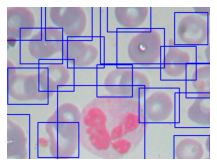

In [22]:
view_sample_result()

In [ ]:
EPOCHS = 10
optimizer = tf.keras.optimizers.Adam(lr=1e-4)
global_steps = tf.Variable(0, trainable=False, dtype=tf.int64)
writer = tf.summary.create_file_writer("./log")

for epoch in range(EPOCHS):
  batch = 0
  dataset_gen = get_img_targetScores_targetBboxes_targetMasks()
  for data in dataset_gen:
    batch+= 1 
    print(f"batch {batch}", end="\r")
    global_steps.assign_add(1)
    
    image_data, target_scores, target_bboxes, target_masks = data
    
    with tf.GradientTape() as tape:
      pred_scores, pred_bboxes = RPN(image_data)

      score_loss = tf.nn.softmax_cross_entropy_with_logits(labels=target_scores, logits=pred_scores) 
      foreground_background_mask = tf.cast(tf.math.abs(target_masks) == 1, tf.float32)
      # place to include the loss come from negative sample to further penalize:
      score_loss = tf.reduce_sum(score_loss * foreground_background_mask, axis=[1,2,3]) / tf.reduce_sum(foreground_background_mask)
      score_loss = tf.reduce_mean(score_loss)

      boxes_loss = tf.math.abs(target_bboxes - pred_bboxes)
      boxes_loss = 0.5 * tf.math.pow(boxes_loss, 2) * tf.cast(boxes_loss<1, tf.float32) + (boxes_loss - 0.5) * tf.cast(boxes_loss >=1, tf.float32)
      boxes_loss = tf.reduce_sum(boxes_loss, axis=-1)
      foreground_mask = tf.cast(target_masks > 0, tf.float32)
      boxes_loss = tf.reduce_sum(boxes_loss * foreground_mask, axis=[1,2,3]) / tf.reduce_sum(foreground_mask)
      boxes_loss = tf.reduce_mean(boxes_loss)  

      total_loss = score_loss + 1. * boxes_loss
       
    gradients = tape.gradient(total_loss, RPN.trainable_variables)
    optimizer.apply_gradients(zip(gradients, RPN.trainable_variables))
        
    print("=> epoch %d  batch %d  total_loss: %.6f  score_loss: %.6f  boxes_loss: %.6f" %(epoch+1, batch+1,
                                                  total_loss.numpy(), score_loss.numpy(), boxes_loss.numpy()))
    # writing summary data
    with writer.as_default():
      tf.summary.scalar("total_loss", total_loss, step=global_steps)
      tf.summary.scalar("score_loss", score_loss, step=global_steps)
      tf.summary.scalar("boxes_loss", boxes_loss, step=global_steps)
    writer.flush()
    if (batch % 30) == 0:
      view_sample_result()
      RPN.save_weights(f"RPN_epoch_{epoch}_{batch}.h5")

=> epoch 1  batch 2  total_loss: 0.387319  score_loss: 0.346893  boxes_loss: 0.040426
=> epoch 1  batch 3  total_loss: 0.395462  score_loss: 0.345956  boxes_loss: 0.049506
=> epoch 1  batch 4  total_loss: 0.395438  score_loss: 0.348782  boxes_loss: 0.046656
=> epoch 1  batch 5  total_loss: 0.388276  score_loss: 0.348392  boxes_loss: 0.039884
=> epoch 1  batch 6  total_loss: 0.399334  score_loss: 0.338991  boxes_loss: 0.060342
=> epoch 1  batch 7  total_loss: 0.354522  score_loss: 0.316032  boxes_loss: 0.038490
=> epoch 1  batch 8  total_loss: 0.386840  score_loss: 0.357040  boxes_loss: 0.029800
=> epoch 1  batch 9  total_loss: 0.345908  score_loss: 0.321453  boxes_loss: 0.024454
=> epoch 1  batch 10  total_loss: 0.412723  score_loss: 0.387188  boxes_loss: 0.025535
=> epoch 1  batch 11  total_loss: 0.375229  score_loss: 0.349961  boxes_loss: 0.025267
=> epoch 1  batch 12  total_loss: 0.343530  score_loss: 0.318150  boxes_loss: 0.025380
=> epoch 1  batch 13  total_loss: 0.330405  score_l

## Test Generator

In [ ]:
dataset_gen = get_img_targetScores_targetBboxes_targetMasks()

In [ ]:
image_data, target_scores, target_bboxes, target_masks = next(dataset_gen)

In [ ]:
pred_scores, pred_bboxes = RPN(image_data)